# Lab 3

Excercise 3

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Dataset

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

In [3]:
X_test.shape

(10000, 32, 32, 3)

In [4]:
X_train.shape

(45000, 32, 32, 3)

In [5]:
X_valid.shape

(5000, 32, 32, 3)

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [6]:
def set_session_model():

    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    # Build the model

    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
    for _ in range(20):
        model.add(keras.layers.Dense(100,
                                    activation="elu",
                                    kernel_initializer="he_normal"))
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

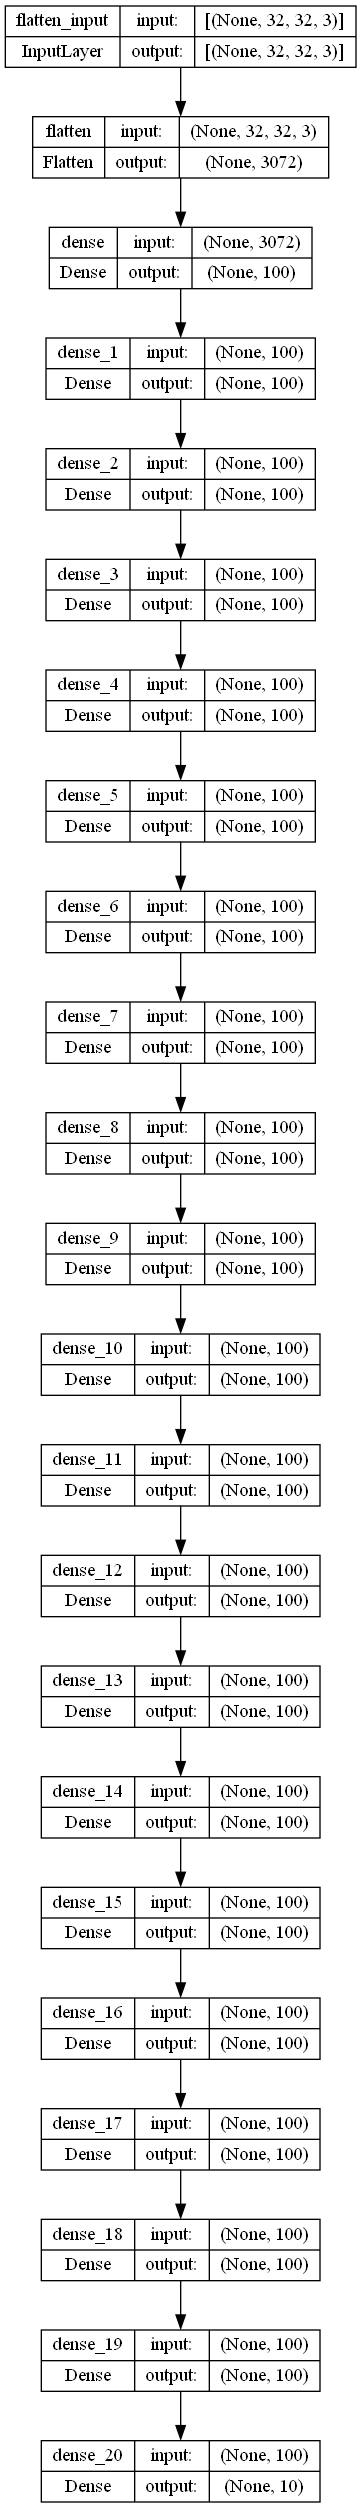

In [24]:
model = set_session_model()

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
# Different learning rates

lr = [1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2]

Find the learning rate by training for 10 epochs and comparing results in learning cures

In [8]:
# 40% are enough to determine the best learning rate and will increase training speed by a lot

X_train_lr = X_train[30000:]
y_train_lr = y_train[30000:]

In [9]:
lr_epochs = 10

for i in range(len(lr)):
    print(f'Learning rate {i+1} out of {len(lr)}')
    model = set_session_model()
    optimizer = keras.optimizers.Nadam(learning_rate=lr[i])
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    history_1 = model.fit(X_train_lr, y_train_lr, epochs=lr_epochs, batch_size=32,validation_data=(X_valid,y_valid))
    if i == 0:
        history_df = pd.DataFrame(history_1.history)
        history_df = history_df.tail(1)
        history_df['lr'] = lr[i]
    else:
        df_add = pd.DataFrame(history_1.history)
        df_add['lr'] = lr[i]
        df_add = df_add.tail(1)
        history_df = pd.concat([history_df, df_add], axis=0)
    print()

history_df.set_index('lr', inplace=True)
cols = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
history_df = history_df[cols]

Learning rate 1 out of 8
Epoch 1/10
469/469 [==============================] - 13s 15ms/step - loss: 33.4525 - accuracy: 0.1100 - val_loss: 8.3644 - val_accuracy: 0.1228
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 5.7128 - accuracy: 0.1238 - val_loss: 3.9841 - val_accuracy: 0.1200
Epoch 3/10
469/469 [==============================] - 5s 11ms/step - loss: 3.3685 - accuracy: 0.1347 - val_loss: 2.9807 - val_accuracy: 0.1418
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 2.8005 - accuracy: 0.1461 - val_loss: 2.6368 - val_accuracy: 0.1576
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 2.5396 - accuracy: 0.1650 - val_loss: 2.4771 - val_accuracy: 0.1684
Epoch 6/10
469/469 [==============================] - 5s 11ms/step - loss: 2.3990 - accuracy: 0.1788 - val_loss: 2.3840 - val_accuracy: 0.1884
Epoch 7/10
469/469 [==============================] - 5s 12ms/step - loss: 2.3171 - accuracy: 0.1886 - val_loss: 2.

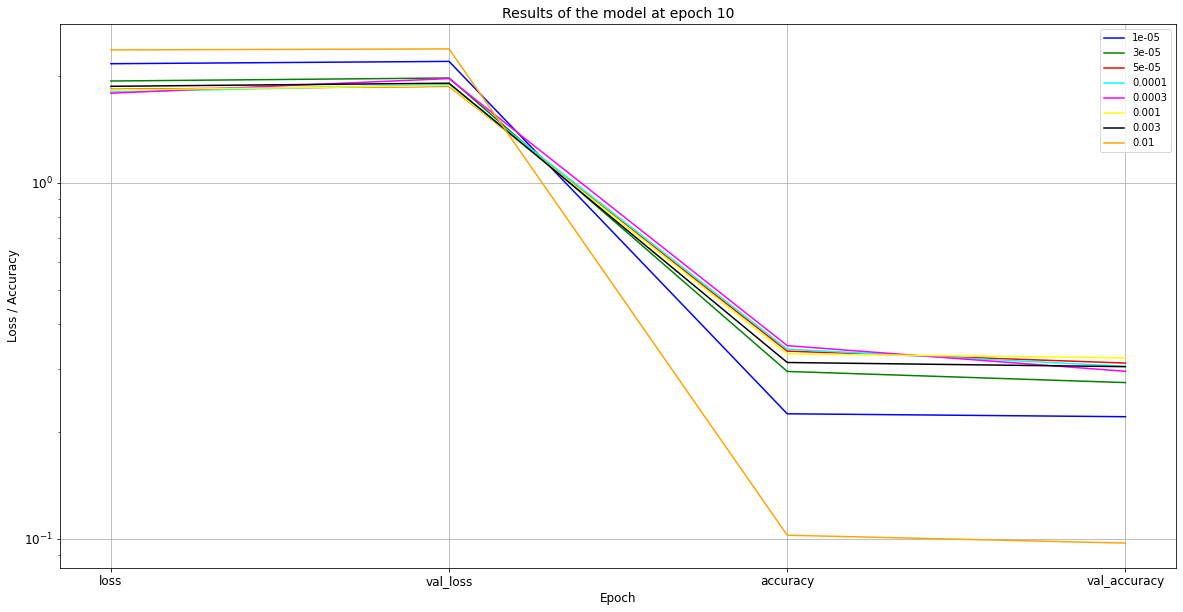

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))
colormap = {lr[0]: 'blue', lr[1]: 'green', lr[2]: 'red', lr[3]: 'cyan', lr[4]: 'magenta', lr[5]: 'yellow', lr[6]: 'black', lr[7]: 'orange'} #, lr[8]: 'brown', lr[9]:}
custom_lines = {}

for name, subdf in history_df.groupby(level='lr'):
    lines = ax.plot(subdf.T, label=name, color=colormap[name])
    custom_lines[name] = lines[0]

ax.set_ylabel('Loss / Accuracy', fontsize=12)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_yscale('log')
ax.grid(True)

plt.title('Results of the model at epoch 10', fontsize=14)

plt.legend(custom_lines.values(), custom_lines.keys())
plt.savefig("lr_comaprison.png", dpi=300)
plt.show()

# # plot them seperately

# lr_epochs = 5

# for i in range(len(lr)):

#     # grab the region that belongs to the learning rate
#     df = history_df.iloc[i*lr_epochs : i*lr_epochs+lr_epochs]

#     df.index += 1

#     # print(df)

#     cols1 = ['loss', 'val_loss']
#     cols2 = ['accuracy', 'val_accuracy']

#     fig, (ax1, ax2) = plt.subplots(1, 2)

#     fig.set_size_inches(20, 6)

#     ax1.plot(df[cols1])
#     ax1.grid(True)
#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Loss')
#     ax1.set_xlim(left=1)
#     ax1.legend(cols1)

#     ax2.plot(df[cols2])
#     ax2.grid(True)
#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('Accuracy')
#     ax2.set_xlim(left=1)
#     ax2.legend(cols2)

#     fig.suptitle('Learning Rate = ' + str(lr[i]))
#     plt.show()

In [11]:
# chosen learning rate for the architecture is: 5e-05
# was chosen by the author and is proven now

With the good learning rate found, the model can be fully trained

In [35]:
model = set_session_model()

optimizer = keras.optimizers.Nadam(learning_rate=5e-05)
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
#run_index = 1 # increment every time you train the model
#run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))

callbacks = [early_stopping_cb, model_checkpoint_cb] #, tensorboard_cb]

history_1 = model.fit(X_train, y_train, epochs=40, callbacks=callbacks, batch_size=32,validation_data=(X_valid,y_valid))

# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

Epoch 1/40
1407/1407 [==============================] - 23s 12ms/step - loss: 5.0357 - accuracy: 0.1752 - val_loss: 2.2094 - val_accuracy: 0.2116
Epoch 2/40
1407/1407 [==============================] - 16s 11ms/step - loss: 2.1027 - accuracy: 0.2351 - val_loss: 2.1715 - val_accuracy: 0.2218
Epoch 3/40
1407/1407 [==============================] - 15s 11ms/step - loss: 1.9611 - accuracy: 0.2816 - val_loss: 2.0308 - val_accuracy: 0.2572
Epoch 4/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.8814 - accuracy: 0.3096 - val_loss: 1.9806 - val_accuracy: 0.2786
Epoch 5/40
1407/1407 [==============================] - 15s 11ms/step - loss: 1.8180 - accuracy: 0.3355 - val_loss: 1.8171 - val_accuracy: 0.3412
Epoch 6/40
1407/1407 [==============================] - 16s 12ms/step - loss: 1.7594 - accuracy: 0.3623 - val_loss: 1.8416 - val_accuracy: 0.3336
Epoch 7/40
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7075 - accuracy: 0.3826 - val_loss: 1.7099 -

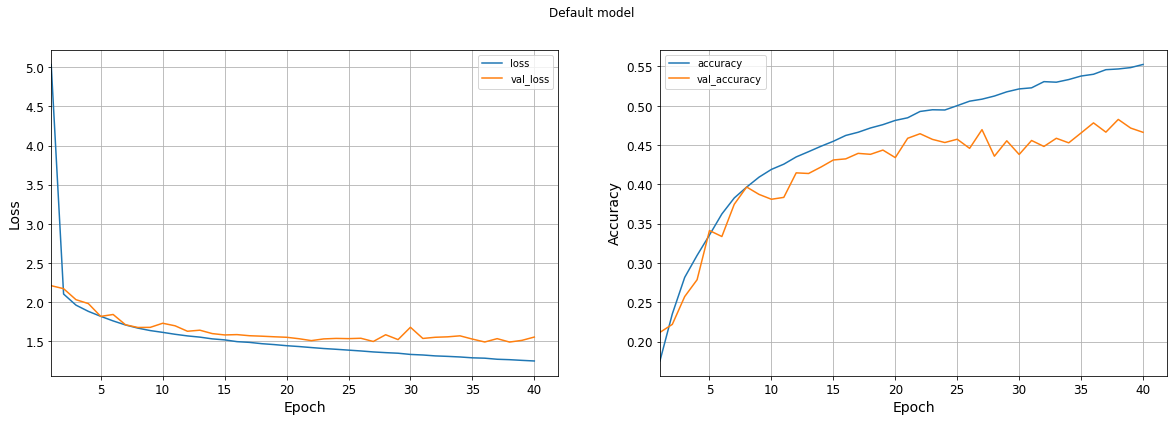

In [39]:
history_df_full = pd.DataFrame(history_1.history)
history_df_full.index += 1

cols1 = ['loss', 'val_loss']
cols2 = ['accuracy', 'val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(20, 6)

ax1.plot(history_df_full[cols1])
ax1.grid(True)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_xlim(left=1)
ax1.legend(cols1)

ax2.plot(history_df_full[cols2])
ax2.grid(True)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_xlim(left=1)
ax2.legend(cols2)

fig.suptitle('Default model')
plt.savefig("curves_normal.png", dpi=300)
plt.show()

In [17]:
# Load the model and evaluate it on the test set

model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4958 - accuracy: 0.4687


[1.4957791566848755, 0.46869999170303345]

The model with the lowest validation loss gets about 46.87% accuracy on the test set. Let's see if we can improve performance using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to my_cifar10_bn_model.h5.

Since the comments from the first author have proven based, the learning rate of 5e-4 for the new architecure from him is used.

In [40]:
def set_session_model_bn():

    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    # Build the model

    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
    model.add(keras.layers.BatchNormalization())
    for _ in range(20):
        model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("elu"))
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

In [41]:
model = set_session_model_bn()

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
#run_index = 1 # increment every time you train the model
#run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))

callbacks = [early_stopping_cb, model_checkpoint_cb] #, tensorboard_cb]

history_bn = model.fit(X_train, y_train, epochs=40, callbacks=callbacks, batch_size=32,validation_data=(X_valid,y_valid))

# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

Epoch 1/40
1407/1407 [==============================] - 34s 15ms/step - loss: 1.8372 - accuracy: 0.3396 - val_loss: 1.6773 - val_accuracy: 0.3888
Epoch 2/40
1407/1407 [==============================] - 20s 14ms/step - loss: 1.6645 - accuracy: 0.4050 - val_loss: 1.5810 - val_accuracy: 0.4278
Epoch 3/40
1407/1407 [==============================] - 20s 15ms/step - loss: 1.5931 - accuracy: 0.4311 - val_loss: 1.5324 - val_accuracy: 0.4464
Epoch 4/40
1407/1407 [==============================] - 20s 14ms/step - loss: 1.5424 - accuracy: 0.4486 - val_loss: 1.5129 - val_accuracy: 0.4584
Epoch 5/40
1407/1407 [==============================] - 22s 16ms/step - loss: 1.5023 - accuracy: 0.4651 - val_loss: 1.4553 - val_accuracy: 0.4800
Epoch 6/40
1407/1407 [==============================] - 22s 15ms/step - loss: 1.4656 - accuracy: 0.4775 - val_loss: 1.4200 - val_accuracy: 0.4852
Epoch 7/40
1407/1407 [==============================] - 22s 15ms/step - loss: 1.4329 - accuracy: 0.4911 - val_loss: 1.4104 -

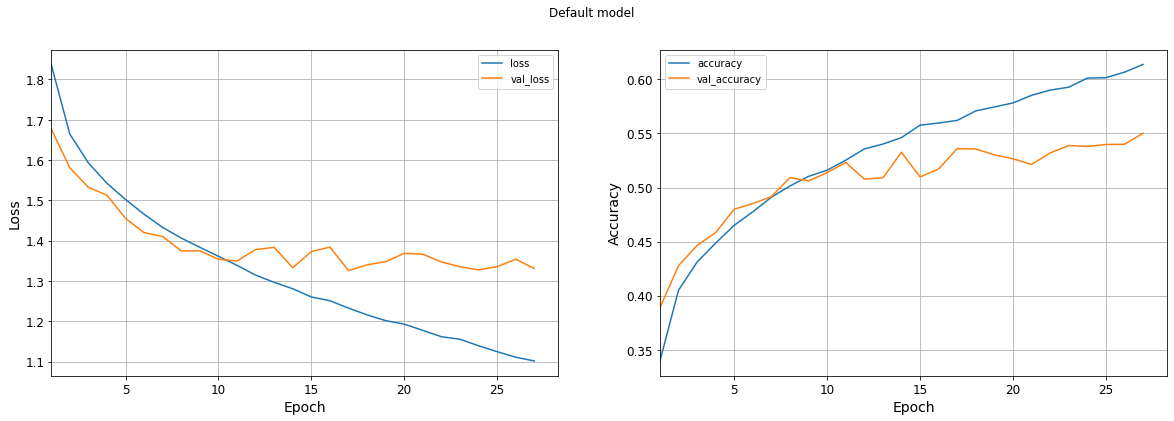

In [42]:
history_df_full_bn = pd.DataFrame(history_bn.history)
history_df_full_bn.index += 1

cols1 = ['loss', 'val_loss']
cols2 = ['accuracy', 'val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(20, 6)

ax1.plot(history_df_full_bn[cols1])
ax1.grid(True)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_xlim(left=1)
ax1.legend(cols1)

ax2.plot(history_df_full_bn[cols2])
ax2.grid(True)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_xlim(left=1)
ax2.legend(cols2)

fig.suptitle('Default model')
plt.savefig("curves_bn.png", dpi=300)
plt.show()

In [22]:
# Load the model and evaluate it on the test set

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.3264 - accuracy: 0.5321


[1.3263570070266724, 0.5321000218391418]

* *Is the model converging faster than before?* Ealry stopping hit after 21 epochs, in the first one it didnt. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.


* *Does BN produce a better model?* Yes! The final model is also much better, with 53.21% accuracy instead of 46.87%.

* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 28s instead of 14s, because of the extra computations required by the BN layers. With 21 epochs trained this leads to a total training time of 28s x 27 = 756s comapred to 14s x 40 = 560s. About the same.

# Faster Optimizers

## Gradient Descent

In [60]:
model = set_session_model_bn()

optimizer=keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_sgd_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb] #, tensorboard_cb]

model.fit(X_train, y_train, epochs=40, callbacks=callbacks,
          validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/40
1407/1407 [==============================] - 19s 10ms/step - loss: 2.1759 - accuracy: 0.2316 - val_loss: 1.9304 - val_accuracy: 0.3118
Epoch 2/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.9110 - accuracy: 0.3157 - val_loss: 1.7879 - val_accuracy: 0.3522
Epoch 3/40
1407/1407 [==============================] - 15s 11ms/step - loss: 1.8250 - accuracy: 0.3490 - val_loss: 1.7295 - val_accuracy: 0.3764
Epoch 4/40
1407/1407 [==============================] - 18s 13ms/step - loss: 1.7670 - accuracy: 0.3674 - val_loss: 1.6804 - val_accuracy: 0.4020
Epoch 5/40
1407/1407 [==============================] - 15s 11ms/step - loss: 1.7285 - accuracy: 0.3846 - val_loss: 1.6474 - val_accuracy: 0.4108
Epoch 6/40
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6989 - accuracy: 0.3946 - val_loss: 1.6184 - val_accuracy: 0.4200
Epoch 7/40
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6698 - accuracy: 0.4060 - val_loss: 1.5980 -

[1.4167993068695068, 0.4952999949455261]

In [61]:
# Load the model and evaluate it on the test set

model = keras.models.load_model("my_cifar10_sgd_model.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 1.4137 - accuracy: 0.4986


[1.4137400388717651, 0.4986000061035156]

## Momentum optimization

In [62]:
model = set_session_model_bn()

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_mom_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb] #, tensorboard_cb]

model.fit(X_train, y_train, epochs=40, callbacks=callbacks,
          validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/40
1407/1407 [==============================] - 25s 11ms/step - loss: 1.8914 - accuracy: 0.3239 - val_loss: 1.6406 - val_accuracy: 0.4192
Epoch 2/40
1407/1407 [==============================] - 16s 12ms/step - loss: 1.6833 - accuracy: 0.4010 - val_loss: 1.5504 - val_accuracy: 0.4480
Epoch 3/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6107 - accuracy: 0.4259 - val_loss: 1.5183 - val_accuracy: 0.4528
Epoch 4/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5648 - accuracy: 0.4443 - val_loss: 1.4838 - val_accuracy: 0.4708
Epoch 5/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5287 - accuracy: 0.4576 - val_loss: 1.4534 - val_accuracy: 0.4778
Epoch 6/40
1407/1407 [==============================] - 15s 11ms/step - loss: 1.4955 - accuracy: 0.4710 - val_loss: 1.4308 - val_accuracy: 0.4916
Epoch 7/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4672 - accuracy: 0.4787 - val_loss: 1.4349 -

[1.3649543523788452, 0.5223000049591064]

In [63]:
# Load the model and evaluate it on the test set

model = keras.models.load_model("my_cifar10_mom_model.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 1.3582 - accuracy: 0.5212


[1.3582203388214111, 0.5212000012397766]

## Nesterov Accelerated Gradient

In [64]:
model = set_session_model_bn()

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_nes_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb] #, tensorboard_cb]

model.fit(X_train, y_train, epochs=40, callbacks=callbacks,
          validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/40
1407/1407 [==============================] - 23s 12ms/step - loss: 1.8924 - accuracy: 0.3178 - val_loss: 1.6674 - val_accuracy: 0.3926
Epoch 2/40
1407/1407 [==============================] - 18s 13ms/step - loss: 1.7019 - accuracy: 0.3866 - val_loss: 1.5827 - val_accuracy: 0.4272
Epoch 3/40
1407/1407 [==============================] - 17s 12ms/step - loss: 1.6222 - accuracy: 0.4212 - val_loss: 1.5206 - val_accuracy: 0.4512
Epoch 4/40
1407/1407 [==============================] - 17s 12ms/step - loss: 1.5704 - accuracy: 0.4394 - val_loss: 1.4813 - val_accuracy: 0.4680
Epoch 5/40
1407/1407 [==============================] - 20s 14ms/step - loss: 1.5319 - accuracy: 0.4537 - val_loss: 1.4539 - val_accuracy: 0.4812
Epoch 6/40
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4957 - accuracy: 0.4678 - val_loss: 1.4332 - val_accuracy: 0.4804
Epoch 7/40
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4657 - accuracy: 0.4792 - val_loss: 1.4297 -

[1.3533052206039429, 0.5333999991416931]

In [65]:
# Load the model and evaluate it on the test set

model = keras.models.load_model("my_cifar10_nes_model.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 1.3517 - accuracy: 0.5277


[1.3516576290130615, 0.5277000069618225]

## AdaGrad

In [50]:
model = set_session_model_bn()

optimizer = keras.optimizers.Adagrad(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_ada_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb] #, tensorboard_cb]

model.fit(X_train, y_train, epochs=40, callbacks=callbacks,
          validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/40
1407/1407 [==============================] - 19s 10ms/step - loss: 2.0358 - accuracy: 0.2708 - val_loss: 1.8062 - val_accuracy: 0.3548
Epoch 2/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.8359 - accuracy: 0.3419 - val_loss: 1.7239 - val_accuracy: 0.3818
Epoch 3/40
1407/1407 [==============================] - 15s 11ms/step - loss: 1.7732 - accuracy: 0.3633 - val_loss: 1.6812 - val_accuracy: 0.3956
Epoch 4/40
1407/1407 [==============================] - 15s 10ms/step - loss: 1.7292 - accuracy: 0.3816 - val_loss: 1.6537 - val_accuracy: 0.4014
Epoch 5/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.7049 - accuracy: 0.3908 - val_loss: 1.6269 - val_accuracy: 0.4138
Epoch 6/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6784 - accuracy: 0.4003 - val_loss: 1.6175 - val_accuracy: 0.4170
Epoch 7/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6575 - accuracy: 0.4111 - val_loss: 1.5999 -

[1.4429547786712646, 0.4869999885559082]

In [51]:
# Load the model and evaluate it on the test set

model = keras.models.load_model("my_cifar10_ada_model.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 3ms/step - loss: 1.4434 - accuracy: 0.4857


[1.4434326887130737, 0.48570001125335693]

## RMSProp

In [52]:
model = set_session_model_bn()

optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_rms_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb] #, tensorboard_cb]

model.fit(X_train, y_train, epochs=40, callbacks=callbacks,
          validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/40
1407/1407 [==============================] - 27s 13ms/step - loss: 1.8770 - accuracy: 0.3258 - val_loss: 1.8474 - val_accuracy: 0.3484
Epoch 2/40
1407/1407 [==============================] - 19s 13ms/step - loss: 1.6969 - accuracy: 0.3960 - val_loss: 1.6936 - val_accuracy: 0.3970
Epoch 3/40
1407/1407 [==============================] - 18s 13ms/step - loss: 1.6216 - accuracy: 0.4236 - val_loss: 1.7395 - val_accuracy: 0.3896
Epoch 4/40
1407/1407 [==============================] - 18s 13ms/step - loss: 1.5650 - accuracy: 0.4423 - val_loss: 1.5567 - val_accuracy: 0.4482
Epoch 5/40
1407/1407 [==============================] - 18s 13ms/step - loss: 1.5208 - accuracy: 0.4616 - val_loss: 1.5822 - val_accuracy: 0.4408
Epoch 6/40
1407/1407 [==============================] - 18s 13ms/step - loss: 1.4795 - accuracy: 0.4752 - val_loss: 1.4747 - val_accuracy: 0.4840
Epoch 7/40
1407/1407 [==============================] - 18s 13ms/step - loss: 1.4472 - accuracy: 0.4878 - val_loss: 1.5433 -

[1.3971933126449585, 0.5321999788284302]

In [53]:
# Load the model and evaluate it on the test set

model = keras.models.load_model("my_cifar10_rms_model.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 3ms/step - loss: 1.3639 - accuracy: 0.5260


[1.3639214038848877, 0.5260000228881836]

## Adam Optimization

In [54]:
model = set_session_model_bn()

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_ado_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb] #, tensorboard_cb]

model.fit(X_train, y_train, epochs=40, callbacks=callbacks,
          validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/40
1407/1407 [==============================] - 21s 11ms/step - loss: 1.8604 - accuracy: 0.3311 - val_loss: 1.7065 - val_accuracy: 0.3938
Epoch 2/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.7018 - accuracy: 0.3933 - val_loss: 1.5988 - val_accuracy: 0.4246
Epoch 3/40
1407/1407 [==============================] - 15s 11ms/step - loss: 1.6349 - accuracy: 0.4184 - val_loss: 1.5865 - val_accuracy: 0.4310
Epoch 4/40
1407/1407 [==============================] - 15s 11ms/step - loss: 1.5824 - accuracy: 0.4375 - val_loss: 1.5647 - val_accuracy: 0.4492
Epoch 5/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5375 - accuracy: 0.4568 - val_loss: 1.4547 - val_accuracy: 0.4840
Epoch 6/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4950 - accuracy: 0.4697 - val_loss: 1.4446 - val_accuracy: 0.4814
Epoch 7/40
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4580 - accuracy: 0.4830 - val_loss: 1.4412 -

[1.360333800315857, 0.5389000177383423]

In [55]:
# Load the model and evaluate it on the test set

model = keras.models.load_model("my_cifar10_ado_model.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 3ms/step - loss: 1.3219 - accuracy: 0.5419


[1.3218802213668823, 0.5418999791145325]

## Adamax Optimization

In [56]:
model = set_session_model_bn()

optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_adx_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb] #, tensorboard_cb]

model.fit(X_train, y_train, epochs=40, callbacks=callbacks,
          validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/40
1407/1407 [==============================] - 22s 11ms/step - loss: 1.8555 - accuracy: 0.3344 - val_loss: 1.6589 - val_accuracy: 0.4120
Epoch 2/40
1407/1407 [==============================] - 17s 12ms/step - loss: 1.6822 - accuracy: 0.4018 - val_loss: 1.5575 - val_accuracy: 0.4422
Epoch 3/40
1407/1407 [==============================] - 17s 12ms/step - loss: 1.5969 - accuracy: 0.4310 - val_loss: 1.5190 - val_accuracy: 0.4528
Epoch 4/40
1407/1407 [==============================] - 17s 12ms/step - loss: 1.5435 - accuracy: 0.4500 - val_loss: 1.4738 - val_accuracy: 0.4774
Epoch 5/40
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4943 - accuracy: 0.4672 - val_loss: 1.4486 - val_accuracy: 0.4852
Epoch 6/40
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4610 - accuracy: 0.4789 - val_loss: 1.4262 - val_accuracy: 0.4992
Epoch 7/40
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4248 - accuracy: 0.4935 - val_loss: 1.3912 -

[1.3512301445007324, 0.5371000170707703]

In [57]:
# Load the model and evaluate it on the test set

model = keras.models.load_model("my_cifar10_adx_model.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 3ms/step - loss: 1.3130 - accuracy: 0.5377


[1.3129856586456299, 0.5376999974250793]

## Nadam Optimization

In [58]:
model = set_session_model_bn()

optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_nad_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb] #, tensorboard_cb]

model.fit(X_train, y_train, epochs=40, callbacks=callbacks,
          validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/40
1407/1407 [==============================] - 31s 14ms/step - loss: 1.8410 - accuracy: 0.3393 - val_loss: 1.6904 - val_accuracy: 0.4000
Epoch 2/40
1407/1407 [==============================] - 21s 15ms/step - loss: 1.6861 - accuracy: 0.4004 - val_loss: 1.6567 - val_accuracy: 0.4086
Epoch 3/40
1407/1407 [==============================] - 21s 15ms/step - loss: 1.6220 - accuracy: 0.4221 - val_loss: 1.5989 - val_accuracy: 0.4274
Epoch 4/40
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5727 - accuracy: 0.4419 - val_loss: 1.5686 - val_accuracy: 0.4484
Epoch 5/40
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5290 - accuracy: 0.4575 - val_loss: 1.4593 - val_accuracy: 0.4742
Epoch 6/40
1407/1407 [==============================] - 21s 15ms/step - loss: 1.4891 - accuracy: 0.4704 - val_loss: 1.4346 - val_accuracy: 0.4918
Epoch 7/40
1407/1407 [==============================] - 21s 15ms/step - loss: 1.4503 - accuracy: 0.4852 - val_loss: 1.4597 -

[1.379041075706482, 0.5324000120162964]

In [59]:
# Load the model and evaluate it on the test set

model = keras.models.load_model("my_cifar10_nad_model.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 1.3267 - accuracy: 0.5372


[1.3267273902893066, 0.5371999740600586]